# Import Packages

In [5]:
import os
import sys
import csv
import random
import platform
import subprocess
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Set Command

In [4]:
os_name = platform.system()
if os_name == "Darwin":
    RSA_command = "./RSA-CLI-macOS"
    process = subprocess.Popen(RSA_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    RSA_ResultFile = "RSA_macOS.csv"
elif os_name == "Linux":
    RSA_command = "./RSA-CLI-Linux"
    process = subprocess.Popen(RSA_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    RSA_ResultFile = "RSA_Linux.csv"
elif os_name == "Windows":
    RSA_command = "RSA-CLI-Windows.exe"
    process = subprocess.Popen(RSA_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    RSA_ResultFile = "RSA_Windows.csv"
else:
    print("OS not supported")
    sys.exit(1)

print("RSA command: ", RSA_command)
print("RSA ResultFile: ", RSA_ResultFile)

RSA command:  ./RSA-CLI-macOS
RSA ResultFile:  RSA_macOS.csv


# Create Input Files

In [10]:
# Create directories
if not os.path.exists("./Container"):
    os.makedirs("./Container")
if not os.path.exists("./Container/Keys"):
    os.makedirs("./Container/Keys")
if not os.path.exists("./Container/Plain"):
    os.makedirs("./Container/Plain")
if not os.path.exists("./Container/Cipher"):
    os.makedirs("./Container/Cipher")
if not os.path.exists("./Container/Recovered"):
    os.makedirs("./Container/Recovered")

# Create a file with random data
def create_file(file_path, size_in_bytes):
    with open(file_path, 'wb') as f:
        random_bytes = bytearray(os.urandom(size_in_bytes))
        for i in range(size_in_bytes):
            random_bytes[i] = random.randint(32, 126)  # ASCII characters from space to tilde
        f.write(random_bytes)

# Create files with sizes 
sizes = [128, 256, 512, 1024, 2048]

for size in sizes:
    FileName = f"Plain_{size}.txt"
    FilePath = "./Container/Plain/" + FileName
    create_file(FilePath, int(size/8))
    print(f"File {FileName} created with size {size} bits")

File Plain_128.txt created with size 128 bits
File Plain_256.txt created with size 256 bits
File Plain_512.txt created with size 512 bits
File Plain_1024.txt created with size 1024 bits
File Plain_2048.txt created with size 2048 bits


# Run RSA Test

In [7]:
KeyDirectory = "./Container/Keys/"
PlainDirectory = "./Container/Plain/Plain_"
CipherDirectory = "./Container/Cipher/Cipher_"
RecoveredDirectory = "./Container/Recovered/Recovered_"

FileSizes = [128, 256, 512, 1024, 2048]
Formats = ["DER", "Base64", "HEX"]
KeySizes = [3072, 4096, 5120]
defaultloops = 222

def GenarateKey(keysize, format):
    if format == "DER":
        command = f"{RSA_command} keygen {keysize} DER {KeyDirectory}pri{keysize}.bin {KeyDirectory}pub{keysize}.bin"
    elif format == "Base64":
        command = f"{RSA_command} keygen {keysize} Base64 {KeyDirectory}pri{keysize}.pem {KeyDirectory}pub{keysize}.pem"
    else:
        command = f"{RSA_command} keygen {keysize} HEX {KeyDirectory}pri{keysize}.hex {KeyDirectory}pub{keysize}.hex"

    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    
    return output.decode("utf-8"), error.decode("utf-8")

def RSA_Excution(keysize, format, filesize):
    if format == "DER":
        EncryptCommand = f"{RSA_command} encrypt DER {KeyDirectory}pub{keysize}.bin {PlainDirectory}{filesize}.txt {CipherDirectory}{filesize}.pem"
        DecryptCommand = f"{RSA_command} decrypt DER {KeyDirectory}pri{keysize}.bin {RecoveredDirectory}{filesize}.txt {CipherDirectory}{filesize}.pem"
    elif format == "Base64":
        EncryptCommand = f"{RSA_command} encrypt Base64 {KeyDirectory}pub{keysize}.pem {PlainDirectory}{filesize}.txt {CipherDirectory}{filesize}.pem"
        DecryptCommand = f"{RSA_command} decrypt Base64 {KeyDirectory}pri{keysize}.pem {RecoveredDirectory}{filesize}.txt {CipherDirectory}{filesize}.pem"
    else:
        EncryptCommand = f"{RSA_command} encrypt HEX {KeyDirectory}pub{keysize}.hex {PlainDirectory}{filesize}.txt {CipherDirectory}{filesize}.pem"
        DecryptCommand = f"{RSA_command} decrypt HEX {KeyDirectory}pri{keysize}.hex {RecoveredDirectory}{filesize}.txt {CipherDirectory}{filesize}.pem"
    
    process = subprocess.Popen(EncryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    EncryptionTime = output.decode("utf-8")
    EncryptionError = error.decode("utf-8")

    process = subprocess.Popen(DecryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    DecryptionTime = output.decode("utf-8")
    DecryptionError = error.decode("utf-8")

    return EncryptionTime, EncryptionError, DecryptionTime, DecryptionError

print("Start running RSA test...\n")

with open(RSA_ResultFile, "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["KeySize", "Format", "File", "Encryption_Time", "Decryption_Time"])
    
    for keysize in KeySizes:
        for format in Formats:
            # Genarate Key and IV
            output, error = GenarateKey(keysize, format)
            if error:
                print(error)
                sys.exit(1)
            print(f"  [ {keysize} | {format} ]")

            for filesize in FileSizes:
                file = f"Plain_{filesize}.txt"
                print(f"    Executing {file}...")
                i = 0
                while i < defaultloops:
                    # RSA Encryption and Decryption
                    EncryptionTime, EncryptionError, DecryptionTime, DecryptionError = RSA_Excution(keysize, format, filesize)
                    if EncryptionError:
                        print(f"*** Encryption error for {file}: {EncryptionError}")
                        sys.exit(1)
                    if DecryptionError:
                        print(f"*** Decryption error for {file}: {DecryptionError}")
                        sys.exit(1)
                    # Write results to file
                    writer.writerow([keysize, format, file, EncryptionTime, DecryptionTime])
                    i = i + 1
                    
print("\nSuccessfully run RSA test!")

Start running RSA test...

  [ 3072 | DER ]
    Executing Plain_128.txt...
    Executing Plain_256.txt...
    Executing Plain_512.txt...
    Executing Plain_1024.txt...
    Executing Plain_2048.txt...
  [ 3072 | Base64 ]
    Executing Plain_128.txt...
    Executing Plain_256.txt...
    Executing Plain_512.txt...
    Executing Plain_1024.txt...
    Executing Plain_2048.txt...
  [ 3072 | HEX ]
    Executing Plain_128.txt...
    Executing Plain_256.txt...
    Executing Plain_512.txt...
    Executing Plain_1024.txt...
    Executing Plain_2048.txt...
  [ 4096 | DER ]
    Executing Plain_128.txt...
    Executing Plain_256.txt...
    Executing Plain_512.txt...
    Executing Plain_1024.txt...
    Executing Plain_2048.txt...
  [ 4096 | Base64 ]
    Executing Plain_128.txt...
    Executing Plain_256.txt...
    Executing Plain_512.txt...
    Executing Plain_1024.txt...
    Executing Plain_2048.txt...
  [ 4096 | HEX ]
    Executing Plain_128.txt...
    Executing Plain_256.txt...
    Executing Plai

# Compare the results of different OS and Input Sizes

RSA Results:
         OS            File  Encryption_Mean  Decryption_Mean
0     Linux   Plain_128.txt            0.768           12.110
1     Linux   Plain_256.txt            0.792           12.419
2     Linux   Plain_512.txt            0.785           12.324
3     Linux  Plain_1024.txt            0.805           12.158
4     Linux  Plain_2048.txt            0.775           12.174
5     macOS   Plain_128.txt            0.455           14.455
6     macOS   Plain_256.txt            0.416           14.554
7     macOS   Plain_512.txt            0.450           14.542
8     macOS  Plain_1024.txt            0.501           14.599
9     macOS  Plain_2048.txt            0.444           14.480
10  Windows   Plain_128.txt            2.628           13.225
11  Windows   Plain_256.txt            2.549           13.197
12  Windows   Plain_512.txt            2.519           13.109
13  Windows  Plain_1024.txt            2.563           13.256
14  Windows  Plain_2048.txt            2.548           13

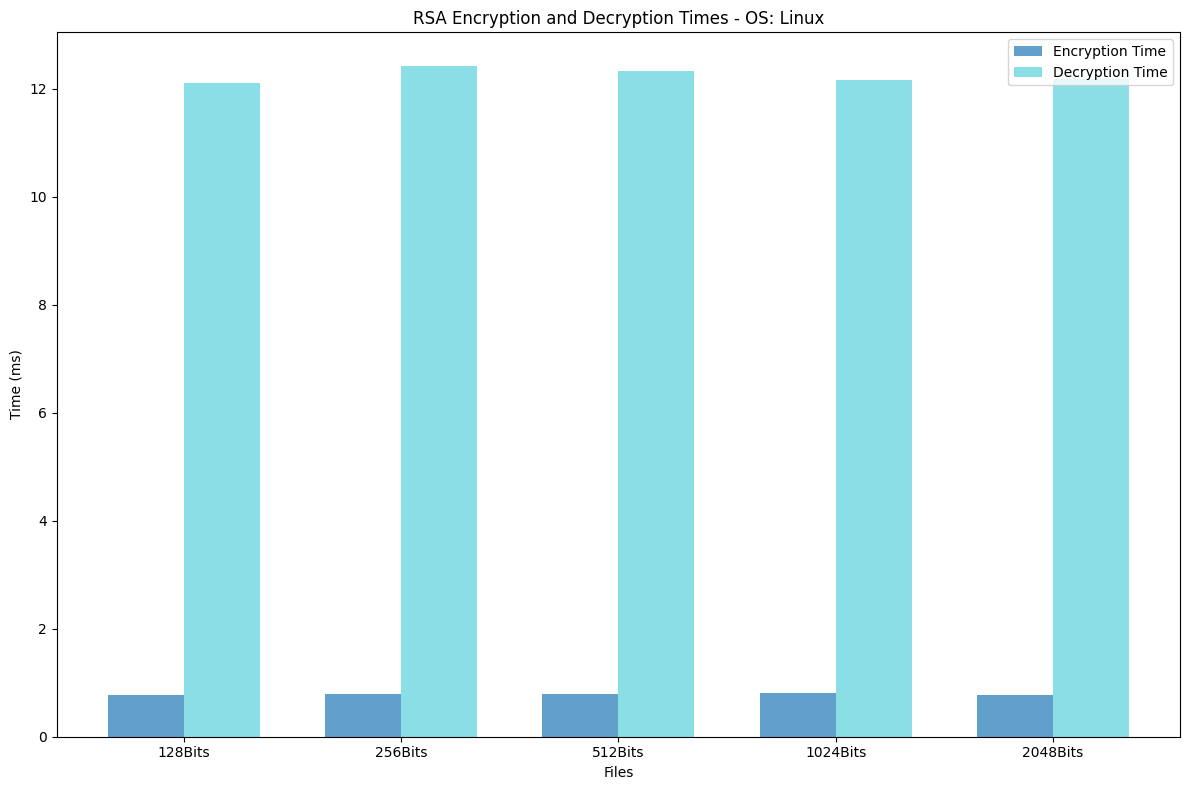

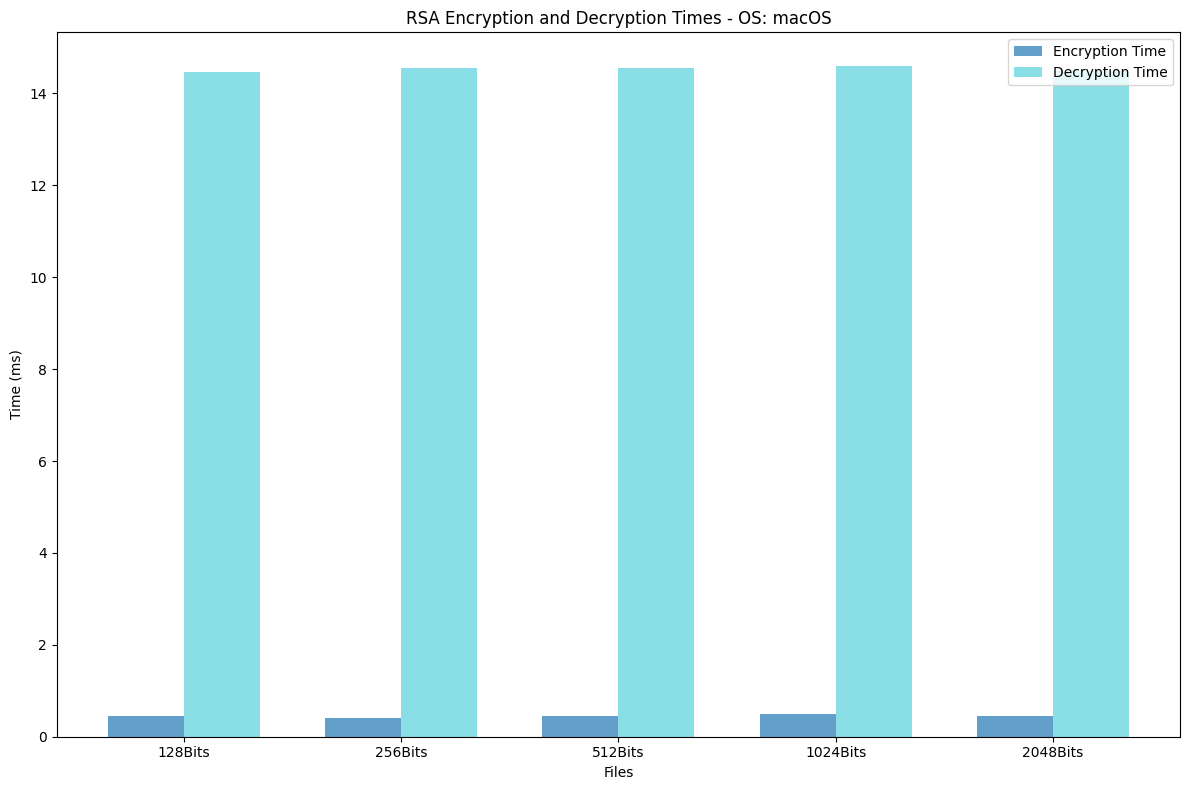

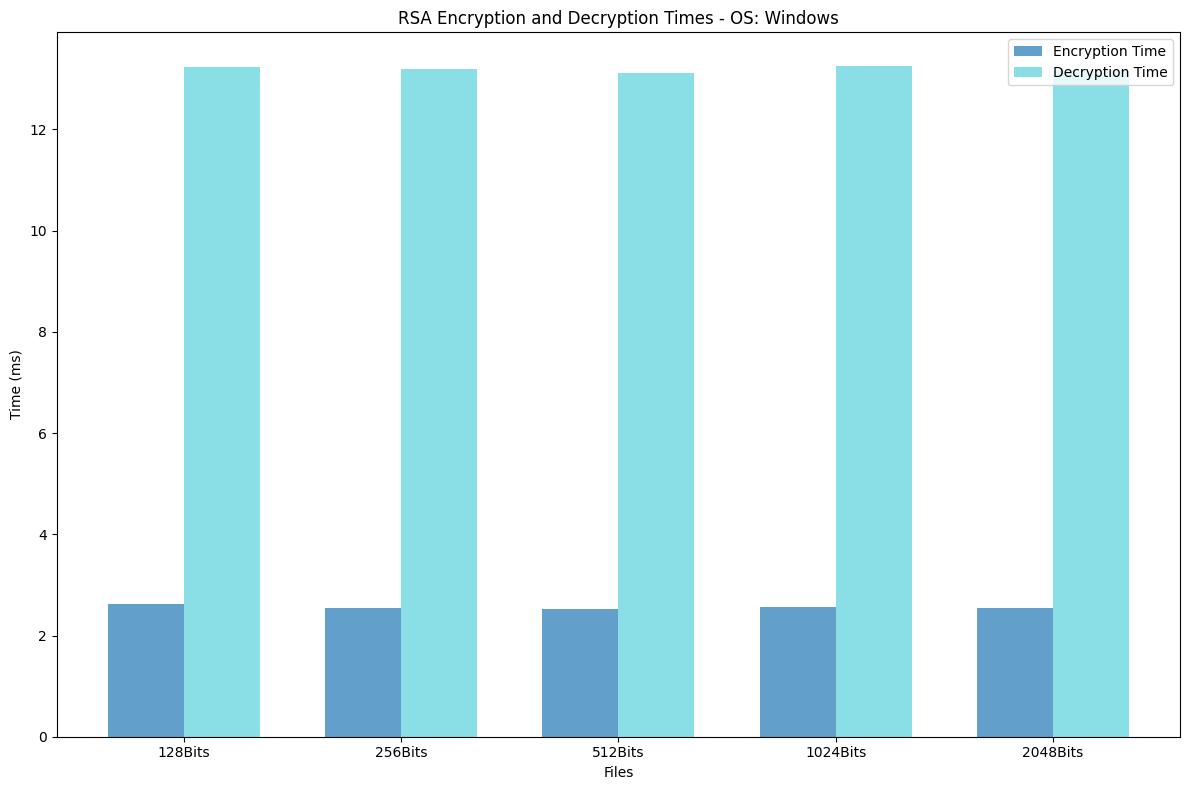

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# CSV files containing the results of the RSA tests
files = {
    'RSA_Linux': './RSA_Linux.csv',
    'RSA_macOS': './RSA_macOS.csv',
    'RSA_Windows': './RSA_Windows.csv'
}

# Initialize a list to store the results
results_RSA = []

# Read the results from the CSV files
for label, file_path in files.items():
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        if not df.empty:
            # Calculate the mean encryption and decryption times for each file
            for file_name in df['File'].unique():
                encryption_mean = df[df['File'] == file_name]['Encryption_Time'].astype(float).mean()
                decryption_mean = df[df['File'] == file_name]['Decryption_Time'].astype(float).mean()

                # Add the results to the list
                results_RSA.append({
                    'OS': label.split('_')[1],
                    'File': file_name,
                    'Encryption_Mean': round(encryption_mean, 3),
                    'Decryption_Mean': round(decryption_mean, 3)
                })

# Convert the results list to a DataFrame
results_df_RSA = pd.DataFrame(results_RSA)

# Check if the DataFrame is empty
if results_df_RSA.empty:
    print("No data available for RSA.")
else:
    # Show RSA results
    print("RSA Results:")
    print(results_df_RSA)
    print()

    # Specify the file order
    file_order = ['Plain_128.txt', 'Plain_256.txt', 'Plain_512.txt', 'Plain_1024.txt', 'Plain_2048.txt']

    # Ensure the results are in the specified order
    results_df_RSA['File'] = pd.Categorical(results_df_RSA['File'], categories=file_order, ordered=True)
    results_df_RSA = results_df_RSA.sort_values('File')

    # Create a new column with the 'Plain_' prefix removed and '.txt' replaced by 'Bits'
    results_df_RSA['File_Display'] = results_df_RSA['File'].str.replace('Plain_', '').str.replace('.txt', 'Bits')

    # Determine the number of unique operating systems for plotting
    unique_os = results_df_RSA['OS'].unique()

    # Iterate over each unique OS and plot
    for os_name in unique_os:
        os_df = results_df_RSA[results_df_RSA['OS'] == os_name]

        # Plotting setup
        fig, ax = plt.subplots(figsize=(12, 8))
        width = 0.35
        x = np.arange(len(os_df['File']))

        # Color setup
        colors = cm.tab10(np.linspace(0, 1, 2))

        # Plotting RSA Encryption and Decryption times
        ax.bar(x - width/2, os_df['Encryption_Mean'], width, label='Encryption Time', color=colors[0], alpha=0.7)
        ax.bar(x + width/2, os_df['Decryption_Mean'], width, label='Decryption Time', color=colors[1], alpha=0.5)

        # Add labels and title
        ax.set_xlabel('Files')
        ax.set_ylabel('Time (ms)')
        ax.set_title(f'RSA Encryption and Decryption Times - OS: {os_name}')
        ax.set_xticks(x)
        ax.set_xticklabels(os_df['File_Display'])
        ax.legend()

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()
